# Analysis on Gastric Cancer Histopathology Tissue Image Dataset (GCHTID)

In previous sections, we have established the following:

1. We can use a deep learning model to label benign and malignant tumors
2. We can use various tools (activation maps, segmentation) to identify the features the model uses to make the disctintion between benign and malignant tumors
3. We can use a deep learning model to label the different tissue types in malignant tumors

The goal of this section is to understand how a model is able to differentiate between the different tissue types in malignant tumors by using techiques/tools such as activatation maps and image segmentation. We also want to see if there are certain tissue types that can be more reliably identified/have more significant features than other tissue types. This is important because different tissue types have different features that the model needs to recognize to make a reliable categorization. If the model is using unreliable features to identify tissues types, our results may not be reproducible on other datasets. Also, if certain tissue types are naturally more difficult to identify, it is likely that the model will become biased during training towards the easier to identify tissue types.

In [1]:
import random

random.seed(42)

In [2]:
### Loading all necessary packages
import numpy as np
import pandas as pd
import timm
from tqdm import tqdm
import torch 
import torch.nn
import torchvision.transforms as transforms
from PIL import Image
from pytorch_grad_cam import GradCAM, HiResCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image

In [3]:
### Set device 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [4]:
### Model architecture

import timm
import torch.nn as nn

class AttentionEfficientNetV2(nn.Module):
    def __init__(self, num_classes=8, pretrained=True, dropout_rate=0.3):
        super(AttentionEfficientNetV2, self).__init__()
        
        self.backbone = timm.create_model('tf_efficientnetv2_s', pretrained=pretrained)
        self.num_features = self.backbone.classifier.in_features
        
        self.backbone.classifier = nn.Identity()
        
        self.attention = nn.Sequential(
            nn.Linear(self.num_features, 128),
            nn.BatchNorm1d(128),
            nn.Tanh(),
            nn.Dropout(dropout_rate),
            nn.Linear(128, 1)
        )
        
        self.bn = nn.BatchNorm1d(self.num_features)
        self.dropout = nn.Dropout(dropout_rate)
        self.classifier = nn.Linear(self.num_features, num_classes)
        
    def forward(self, x):
        features = self.backbone(x)
        normalized_features = self.bn(features)
        attention_weights = self.attention(normalized_features).softmax(dim=1)
        weighted_features = normalized_features * attention_weights
        weighted_features = self.dropout(weighted_features)
        output = self.classifier(weighted_features)
        return output, attention_weights

In [5]:
### Loading multiclass classification model
model = AttentionEfficientNetV2(num_classes=8).to(device)
checkpoint = torch.load("/gpfs/scratch/jz4391/deep-learning-final/model_checkpoint_final_state_dict.pth", weights_only=False)
model.load_state_dict(checkpoint)
model

AttentionEfficientNetV2(
  (backbone): EfficientNet(
    (conv_stem): Conv2dSame(3, 24, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn1): BatchNormAct2d(
      24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
      (drop): Identity()
      (act): SiLU(inplace=True)
    )
    (blocks): Sequential(
      (0): Sequential(
        (0): ConvBnAct(
          (conv): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNormAct2d(
            24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
            (drop): Identity()
            (act): SiLU(inplace=True)
          )
          (aa): Identity()
          (drop_path): Identity()
        )
        (1): ConvBnAct(
          (conv): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNormAct2d(
            24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
            (drop): Identity()
      

In [6]:
### Loading in images from the dataset

import os
import numpy as np
from PIL import Image
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms

def load_data_paths(base_path, split="train"):
    split_path = os.path.join(base_path, split)
    
    class_names = sorted([d for d in os.listdir(split_path) if os.path.isdir(os.path.join(split_path, d))])
    class_to_idx = {class_name: idx for idx, class_name in enumerate(class_names)}
    
    image_paths = []
    labels = []
    
    for class_name in class_names:
        class_dir = os.path.join(split_path, class_name)

        for img_name in os.listdir(class_dir):
            if img_name.lower().endswith(('.png', '.jpg', '.jpeg')):
                img_path = os.path.join(class_dir, img_name)
                image_paths.append(img_path)
                labels.append(class_to_idx[class_name])
    
    return image_paths, labels, class_names

base_path = "/gpfs/scratch/jz4391/deep-learning-final/data"
train_paths, train_labels, class_names = load_data_paths(base_path, "train")
val_paths, val_labels, _ = load_data_paths(base_path, "val")
test_paths, test_labels, _ = load_data_paths(base_path, "test")

print(f"Classes: {class_names}")
print(f"Training images: {len(train_paths)}")
print(f"Validation images: {len(val_paths)}")
print(f"Test images: {len(test_paths)}")


Classes: ['ADI', 'DEB', 'LYM', 'MUC', 'MUS', 'NOR', 'STR', 'TUM']
Training images: 21760
Validation images: 3112
Test images: 6224


In [138]:
class GastricCancerDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform
        
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        image = Image.open(image_path).convert('RGB')
        label = self.labels[idx]
        
        if self.transform:
            image = self.transform(image)
            
        return image, label

train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(10),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_dataset = GastricCancerDataset(train_paths, train_labels, transform=train_transform)
val_dataset = GastricCancerDataset(val_paths, val_labels, transform=val_transform)
test_dataset = GastricCancerDataset(test_paths, test_labels, transform=val_transform)

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

for images, labels in train_loader:
    print(f"Batch images shape: {images.shape}")
    print(f"Batch labels shape: {labels.shape}")
    break

Batch images shape: torch.Size([32, 3, 224, 224])
Batch labels shape: torch.Size([32])


In [ ]:
import matplotlib.pyplot as plt

model.eval()

target_layers = [model.backbone.blocks[-1][-1]]

cam = GradCAM(model=model, target_layers=target_layers)

i = 0
for images, labels in test_loader:
    images, labels = images.to(device), labels.to(device)

    with torch.no_grad():
        output, _ = model(input_tensor)
        pred_class_idx = torch.argmax(output, dim=1).item()
    
    # normalization
    rgb_images = images.permute(0, 2, 3, 1).cpu().numpy()
    rgb_images = (rgb_images - rgb_images.min()) / (rgb_images.max() - rgb_images.min())

    input_tensor = images[0].unsqueeze(0)
    class_idx = labels[0].item()

    targets = [ClassifierOutputTarget(class_idx)]
    grayscale_cam = cam(input_tensor=input_tensor, targets=targets, aug_smooth=True, eigen_smooth=True)
    grayscale_cam = grayscale_cam[0]

    visualization = show_cam_on_image(rgb_images[0], grayscale_cam, use_rgb=True)
    
    plt.imshow(visualization)
    plt.title(f'True: {class_idx}, Predicted: {pred_class_idx}')
    plt.savefig("/gpfs/scratch/jz4391/deep-learning-final/grad_cams_base_classifier/" + str(i) + ".png")
    plt.show()
    i = i + 1



From the activation mappings, we can see that the model can recognize some of the important features associated with each class. For example, class 0 (ADI) is defined by large "emptier" areas, class 1 (DEB) is defined by hotspots of clustered cells, etc. However, there are many cases where the map shows that the model doesn't necessarily use these features for every classification. The model seems to confuse the tissue from the background in many of the images. It also seems to rely a lot on the color value of the image. This leads to some errors/mislabelling since the model isn't using the optimal features to make its classifications.

This leads us to UNet. We can try to segment/mask the images to see if we can help our classification model use more consistent features to identify the images and hopefully improve performance.

In [55]:
### Loading necessary packages
import gc
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from tqdm import tqdm
import matplotlib.pyplot as plt

In [47]:
### UNet Model architecture
# Note: model archiecture is inspired by Pytorch-Unet architecture at https://github.com/milesial/Pytorch-UNet

class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

class UNet(nn.Module):
    def __init__(self, n_channels, n_classes):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes

        self.inc = DoubleConv(n_channels, 64)
        self.down1 = nn.Sequential(nn.MaxPool2d(2), DoubleConv(64, 128))
        self.down2 = nn.Sequential(nn.MaxPool2d(2), DoubleConv(128, 256))
        self.down3 = nn.Sequential(nn.MaxPool2d(2), DoubleConv(256, 512))
        self.down4 = nn.Sequential(nn.MaxPool2d(2), DoubleConv(512, 1024))

        self.conv1 = DoubleConv(1024, 512)
        self.conv2 = DoubleConv(512, 256)
        self.conv3 = DoubleConv(256, 128)
        self.conv4 = DoubleConv(128, 64)
        
        self.up1 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.up2 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.up3 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.up4 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)

        self.outc = nn.Conv2d(64, n_classes, kernel_size=1)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)

        x = self.up1(x5)
        x = torch.cat([x, x4], dim=1)
        x = self.conv1(x)

        x = self.up2(x)
        x = torch.cat([x, x3], dim=1)
        x = self.conv2(x)

        x = self.up3(x)
        x = torch.cat([x, x2], dim=1)
        x = self.conv3(x)

        x = self.up4(x)
        x = torch.cat([x, x1], dim=1)
        x = self.conv4(x)

        logits = self.outc(x)
        return logits


In [116]:
def visualize_unet_masks(dataloader, model, num_samples=5):
    model.eval()
    
    images, _ = next(iter(dataloader))
    images = images.to(device)

    with torch.no_grad():
        masks = model(images)
        masks = torch.sigmoid(masks) > 0.5
    
    masked_images = images * masks.float()
    images = images.cpu().numpy()
    masked_images = masked_images.cpu().numpy()

    fig, axes = plt.subplots(num_samples, 2, figsize=(10, num_samples * 5))
    
    for i in range(num_samples):
        ax_img, ax_mask = axes[i]
        
        ax_img.imshow(np.transpose(images[i], (1, 2, 0)))
        ax_img.set_title(f"Image {i + 1}")
        ax_img.axis('off')
   
        ax_mask.imshow(masked_images[i, 0], cmap='gray')
        ax_mask.set_title(f"Mask {i + 1}")
        ax_mask.axis('off')

    plt.tight_layout()
    plt.show()


In [109]:
def train_unet(train_loader, model, criterion, optimizer, num_epochs): 
    
    loss_history = []
    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        for images, _ in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
            images = images.to(device)
    
            masks = model(images)
            optimizer.zero_grad()
            loss = criterion(masks, images)
            loss.backward()
            optimizer.step()
    
            total_loss += loss.item()
        avg_loss = total_loss/len(train_loader)
        print(f"Average loss for epoch {epoch}: {avg_loss}")
        loss_history.append(avg_loss)

    return loss_history

def test_unet(test_loader, model, criterion):
    model.eval()
    with torch.no_grad():
        total_loss = 0
        for images, _ in tqdm(test_loader, desc="Testing U-Net"):
            images = images.to(device)
            masks = model(images)
            loss = criterion(masks, images)

            total_loss += loss.item()
            
        avg_loss = total_loss / len(test_loader)
        
    print(f"Test Loss: {avg_loss:.4f}")

In [93]:
unet_model = UNet(n_channels=3, n_classes=3).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(unet_model.parameters(), lr= 1e-4)
loss_history = train_unet(train_loader, unet_model, criterion, optimizer, 20)

Epoch 1/20: 100%|██████████| 680/680 [02:19<00:00,  4.89it/s]


Average loss for epoch 0: 0.37117046243785057


Epoch 2/20: 100%|██████████| 680/680 [02:19<00:00,  4.88it/s]


Average loss for epoch 1: 0.016463212558643563


Epoch 3/20: 100%|██████████| 680/680 [02:18<00:00,  4.91it/s]


Average loss for epoch 2: 0.010847313039908733


Epoch 4/20: 100%|██████████| 680/680 [02:18<00:00,  4.91it/s]


Average loss for epoch 3: 0.007128884260857697


Epoch 5/20: 100%|██████████| 680/680 [02:17<00:00,  4.93it/s]


Average loss for epoch 4: 0.005885109170134563


Epoch 6/20: 100%|██████████| 680/680 [02:20<00:00,  4.84it/s]


Average loss for epoch 5: 0.004478024422732072


Epoch 7/20: 100%|██████████| 680/680 [02:19<00:00,  4.87it/s]


Average loss for epoch 6: 0.004163616318221423


Epoch 8/20: 100%|██████████| 680/680 [02:23<00:00,  4.74it/s]


Average loss for epoch 7: 0.003581318359561812


Epoch 9/20: 100%|██████████| 680/680 [02:20<00:00,  4.85it/s]


Average loss for epoch 8: 0.0029140962595941827


Epoch 10/20: 100%|██████████| 680/680 [02:20<00:00,  4.86it/s]


Average loss for epoch 9: 0.0027347869267139364


Epoch 11/20: 100%|██████████| 680/680 [02:19<00:00,  4.89it/s]


Average loss for epoch 10: 0.0023770033365615425


Epoch 12/20: 100%|██████████| 680/680 [02:18<00:00,  4.93it/s]


Average loss for epoch 11: 0.002097982634458116


Epoch 13/20: 100%|██████████| 680/680 [02:18<00:00,  4.92it/s]


Average loss for epoch 12: 0.0021200080382507568


Epoch 14/20: 100%|██████████| 680/680 [02:19<00:00,  4.89it/s]


Average loss for epoch 13: 0.0019471544078174595


Epoch 15/20: 100%|██████████| 680/680 [02:21<00:00,  4.80it/s]


Average loss for epoch 14: 0.0019244506137671552


Epoch 16/20: 100%|██████████| 680/680 [02:27<00:00,  4.61it/s]


Average loss for epoch 15: 0.001757262045986649


Epoch 17/20: 100%|██████████| 680/680 [02:23<00:00,  4.75it/s]


Average loss for epoch 16: 0.0019071747180800338


Epoch 18/20: 100%|██████████| 680/680 [02:18<00:00,  4.91it/s]


Average loss for epoch 17: 0.0015641144252560265


Epoch 19/20: 100%|██████████| 680/680 [02:18<00:00,  4.93it/s]


Average loss for epoch 18: 0.0016295869088293437


Epoch 20/20: 100%|██████████| 680/680 [02:17<00:00,  4.95it/s]

Average loss for epoch 19: 0.0013626353772398193


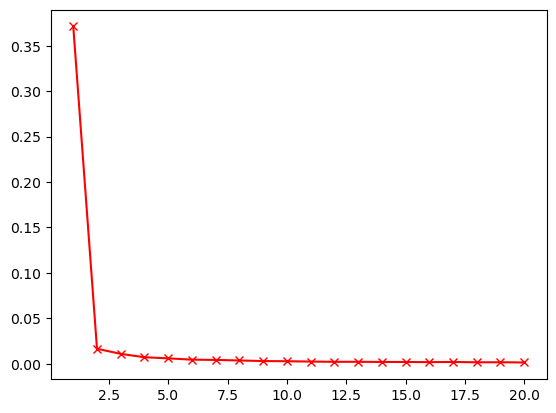

In [94]:
epoch_list = list(range(1,21))
plt.plot(epoch_list, loss_history, '-rx', label="Average Training Loss")

In [110]:
test_unet(test_loader, unet_model, criterion)

Testing U-Net: 100%|██████████| 195/195 [00:23<00:00,  8.38it/s]

Test Loss: 0.0005


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


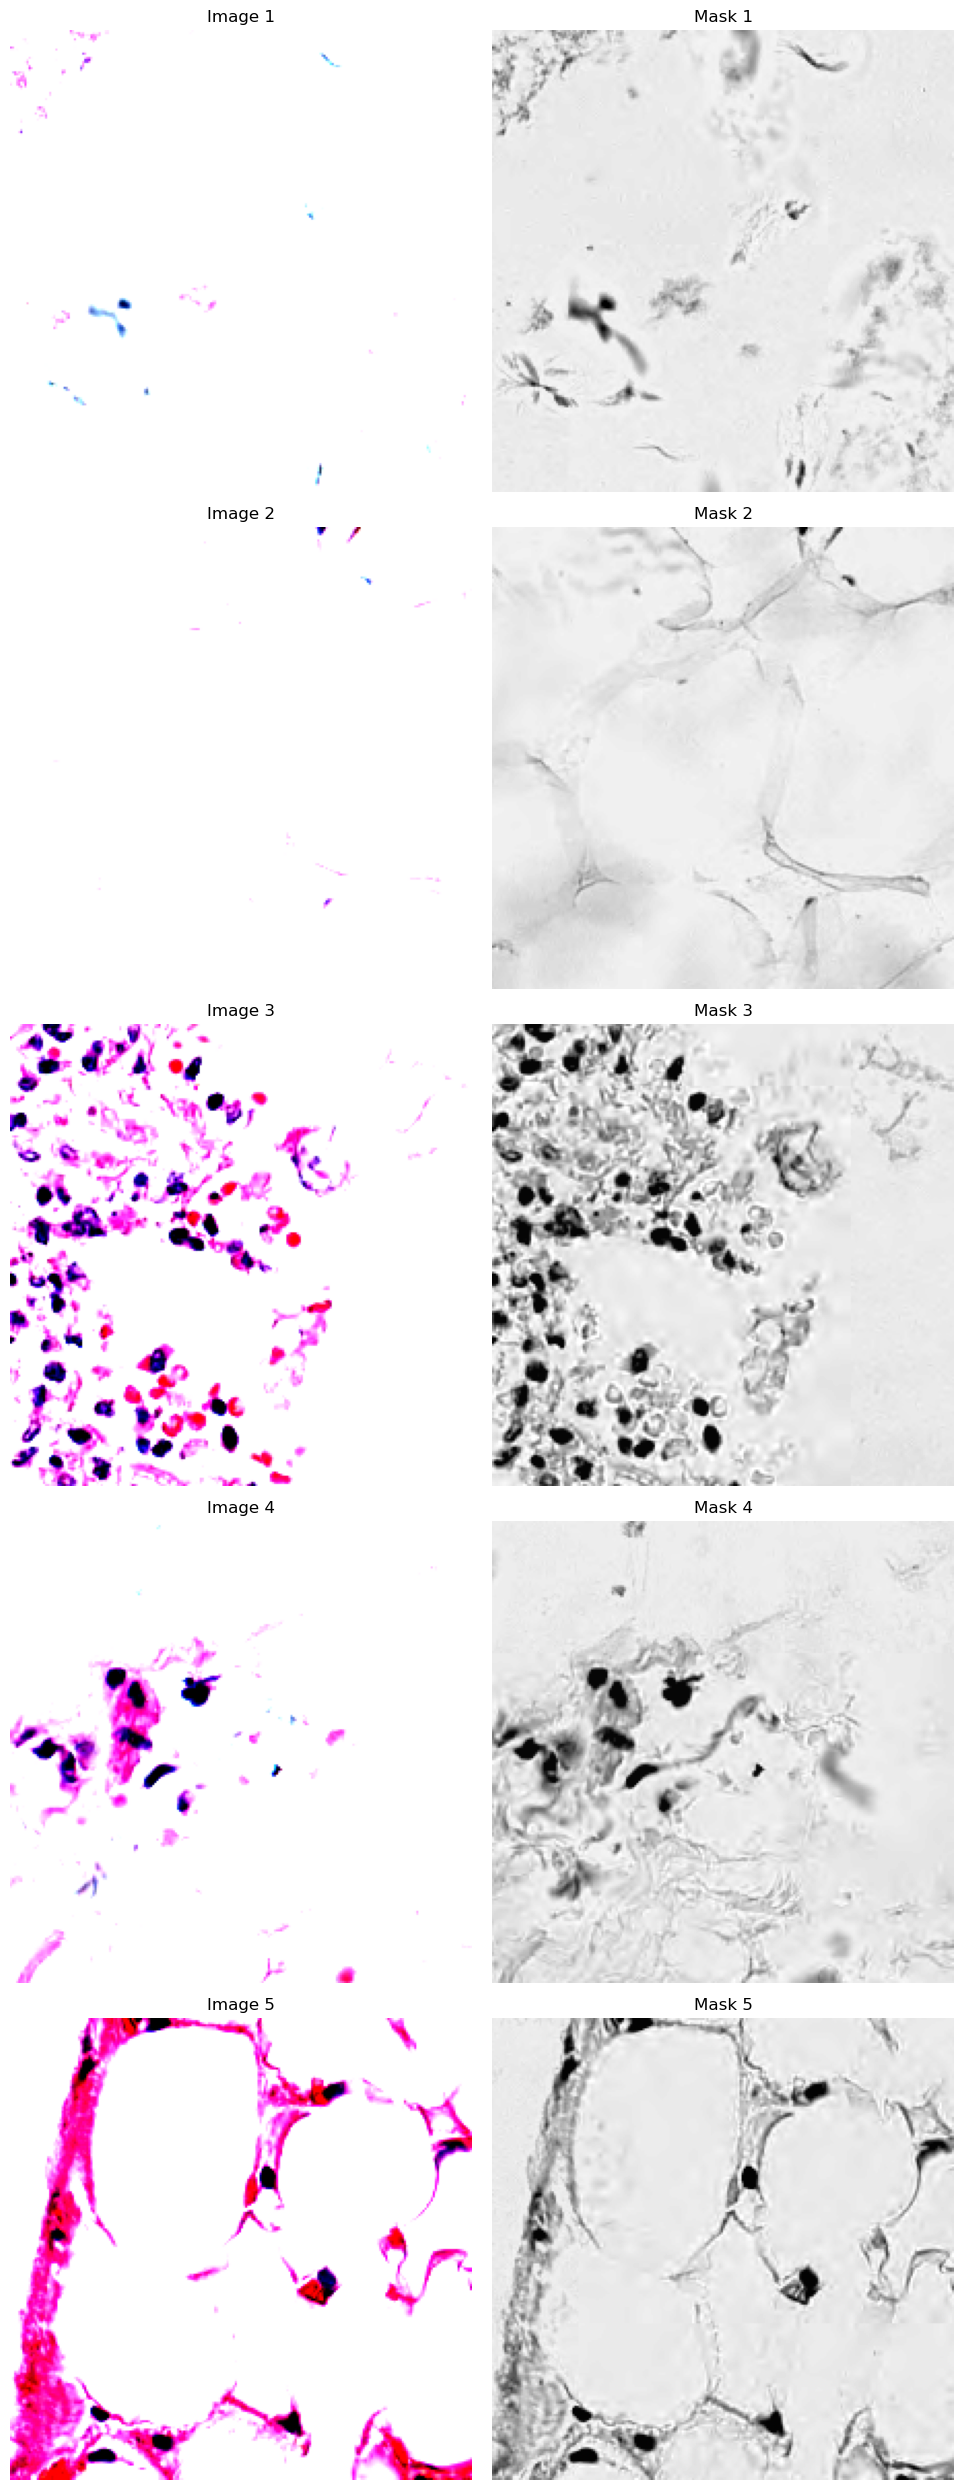

In [117]:
visualize_unet_masks(test_loader, unet_model)

As we can see from the output of UNet, improves the visibility of the various features of the images. Theroetically, this should help our classification model to recognize better key patterns for image labelling, relying more on shapes and textures rather than color.

In [149]:
from sklearn.metrics import roc_auc_score

def train_classifer(train_loader, unet_model, classifier_model, criterion, optimizer, num_epochs):
    loss_history = []
    accuracy_history = []

    unet_model.eval()
    classifier_model.train()
    
    for epoch in range(num_epochs):
        total_loss = 0
        correct = 0
        total = 0
        
        for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            
            with torch.no_grad():
                masks = unet_model(images)
                masks = torch.sigmoid(masks) > 0.5
                
            masked_images = images * masks.float()
            
            outputs, _ = classifier_model(masked_images)
            loss = criterion(outputs, labels)
            
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
            
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
        
        avg_loss = total_loss/len(train_loader)
        avg_accuracy = correct / total

        loss_history.append(avg_loss)
        accuracy_history.append(avg_accuracy)
        
        print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {avg_loss:.4f}, Accuracy: {avg_accuracy:.4f}")

    return loss_history, accuracy_history



def test_classifer(test_loader, unet_model, classifier_model, criterion):
    unet_model.eval()
    classifier_model.eval()
    
    total_loss = 0
    all_labels = []
    all_probs = []
    total = 0
    correct = 0
    
    with torch.no_grad():
        for images, labels in tqdm(test_loader, desc="Test Classifier"):
            images, labels = images.to(device), labels.to(device)
            
            masks = unet_model(images)
            masks = torch.sigmoid(masks) > 0.5
            
            masked_images = images * masks.float()
            
            outputs, _ = classifier_model(masked_images)
            
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            
            _, predicted = outputs.max(1)
            
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
            
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(torch.softmax(outputs, dim=1).cpu().numpy())
    
    test_loss = total_loss / len(test_loader)
    test_accuracy = correct / total
    test_auc = roc_auc_score(all_labels, all_probs, multi_class='ovr', average='macro')
    
    print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}, Test AUC: {test_auc:.4f}")
    
    return test_loss, test_accuracy, test_auc



In [144]:
### New Classifier model uses the same metrics as the previous one

classifier_model = AttentionEfficientNetV2(num_classes=8).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(classifier_model.parameters(), lr=1e-4, weight_decay=1e-5)

loss_history, accuracy_history = train_classifer(train_loader, unet_model, classifier_model, criterion, optimizer, 20)

Epoch 1/20: 100%|██████████| 680/680 [01:59<00:00,  5.69it/s]


Epoch 1/20, Loss: 1.0694, Accuracy: 0.6028


Epoch 2/20: 100%|██████████| 680/680 [01:54<00:00,  5.92it/s]


Epoch 2/20, Loss: 0.7973, Accuracy: 0.7005


Epoch 3/20: 100%|██████████| 680/680 [02:09<00:00,  5.23it/s]


Epoch 3/20, Loss: 0.6893, Accuracy: 0.7397


Epoch 4/20: 100%|██████████| 680/680 [01:57<00:00,  5.80it/s]


Epoch 4/20, Loss: 0.6014, Accuracy: 0.7722


Epoch 5/20: 100%|██████████| 680/680 [01:58<00:00,  5.73it/s]


Epoch 5/20, Loss: 0.5245, Accuracy: 0.8071


Epoch 6/20: 100%|██████████| 680/680 [01:55<00:00,  5.90it/s]


Epoch 6/20, Loss: 0.4393, Accuracy: 0.8373


Epoch 7/20: 100%|██████████| 680/680 [01:56<00:00,  5.82it/s]


Epoch 7/20, Loss: 0.3647, Accuracy: 0.8678


Epoch 8/20: 100%|██████████| 680/680 [01:59<00:00,  5.70it/s]


Epoch 8/20, Loss: 0.2971, Accuracy: 0.8921


Epoch 9/20: 100%|██████████| 680/680 [01:55<00:00,  5.90it/s]


Epoch 9/20, Loss: 0.2468, Accuracy: 0.9106


Epoch 10/20: 100%|██████████| 680/680 [02:00<00:00,  5.63it/s]


Epoch 10/20, Loss: 0.2106, Accuracy: 0.9245


Epoch 11/20: 100%|██████████| 680/680 [01:59<00:00,  5.68it/s]


Epoch 11/20, Loss: 0.1830, Accuracy: 0.9334


Epoch 12/20: 100%|██████████| 680/680 [02:00<00:00,  5.66it/s]


Epoch 12/20, Loss: 0.1638, Accuracy: 0.9404


Epoch 13/20: 100%|██████████| 680/680 [01:58<00:00,  5.76it/s]


Epoch 13/20, Loss: 0.1346, Accuracy: 0.9519


Epoch 14/20: 100%|██████████| 680/680 [01:57<00:00,  5.80it/s]


Epoch 14/20, Loss: 0.1358, Accuracy: 0.9527


Epoch 15/20: 100%|██████████| 680/680 [01:56<00:00,  5.85it/s]


Epoch 15/20, Loss: 0.1151, Accuracy: 0.9595


Epoch 16/20: 100%|██████████| 680/680 [01:56<00:00,  5.82it/s]


Epoch 16/20, Loss: 0.1117, Accuracy: 0.9601


Epoch 17/20: 100%|██████████| 680/680 [02:01<00:00,  5.61it/s]


Epoch 17/20, Loss: 0.1046, Accuracy: 0.9642


Epoch 18/20: 100%|██████████| 680/680 [01:55<00:00,  5.87it/s]


Epoch 18/20, Loss: 0.0980, Accuracy: 0.9653


Epoch 19/20: 100%|██████████| 680/680 [01:55<00:00,  5.89it/s]


Epoch 19/20, Loss: 0.0873, Accuracy: 0.9696


Epoch 20/20: 100%|██████████| 680/680 [01:57<00:00,  5.76it/s]

Epoch 20/20, Loss: 0.0900, Accuracy: 0.9692


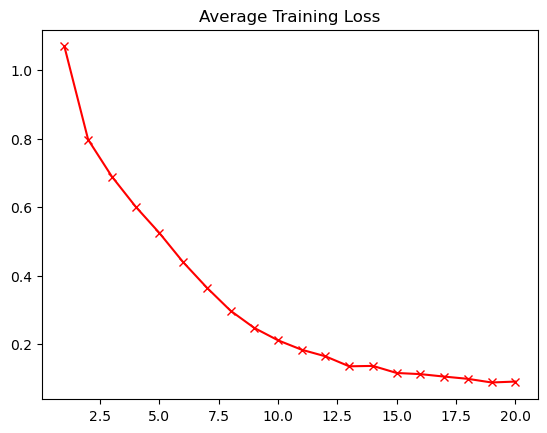

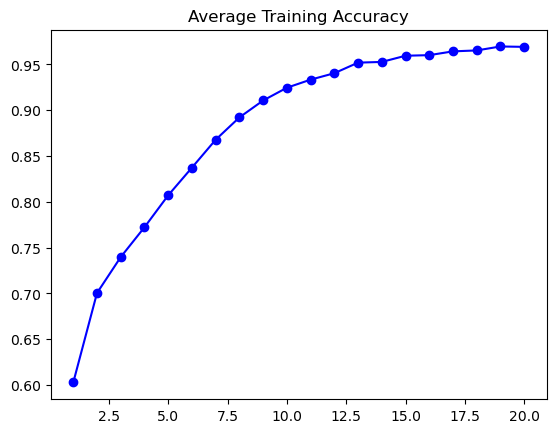

In [145]:
epoch_list = list(range(1,21))
plt.plot(epoch_list, loss_history, '-rx', label="Average Training Loss")
plt.title("Average Training Loss")
plt.show()

plt.plot(epoch_list, accuracy_history, '-bo', label="Average Training Accuracy")
plt.title("Average Training Accuracy")
plt.show()

In [150]:
test_loss, test_accuracy, test_auc = test_classifer(test_loader, unet_model, classifier_model, criterion)

Test Classifier: 100%|██████████| 195/195 [00:30<00:00,  6.40it/s]

Test Loss: 1.2507, Test Accuracy: 0.7224, Test AUC: 0.9534


In [ ]:
import matplotlib.pyplot as plt

classifier_model.eval()

target_layers = [classifier_model.backbone.blocks[-1][-1]]

cam = GradCAM(model=classifier_model, target_layers=target_layers)

i = 0
for images, labels in test_loader:
    images, labels = images.to(device), labels.to(device)
    input_tensor = images[0].unsqueeze(0)

    with torch.no_grad():
        output, _ = classifier_model(input_tensor)
        pred_class_idx = torch.argmax(output, dim=1).item()
    
    # normalization
    rgb_images = images.permute(0, 2, 3, 1).cpu().numpy()
    rgb_images = (rgb_images - rgb_images.min()) / (rgb_images.max() - rgb_images.min())

    class_idx = labels[0].item()

    targets = [ClassifierOutputTarget(class_idx)]
    grayscale_cam = cam(input_tensor=input_tensor, targets=targets, aug_smooth=True, eigen_smooth=True)
    grayscale_cam = grayscale_cam[0]

    visualization = show_cam_on_image(rgb_images[0], grayscale_cam, use_rgb=True)
    
    plt.imshow(visualization)
    plt.title(f'True: {class_idx}, Predicted: {pred_class_idx}')
    plt.savefig("/gpfs/scratch/jz4391/deep-learning-final/grad_cams_unet_classifier/" + str(i) + ".png")
    plt.show()
    i = i + 1


The results of using the UNet masks are actually slightly less optimal than without the masks. It's just barely and could just be up to chance (if we changed the random seed, maybe it would improve). However, the GradCAM results are very different from the previous model and pretty interesting. For example. the model seems to have found a much more reliable pattern for identifying class 0. Now, it looks like it's searching for a pattern of pockets of "empty space" scattered around the image. For class 4, it looks like its looking for hotspots where the cells are clumped together. The patterns are pretty reliable for some classes (e.g. class 0) but really unreliable for other classes (e.g. class 2). The model seems to graviate towards more empty spaces in the image than the previous model, just based on inspecting the GradCAM output visually. 